<a href="https://colab.research.google.com/github/pandemic-tracking/viz-gen/blob/main/gisaid_sequencing_arcmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 6.7 MB/s 
     |████████████████████████████████| 6.3 MB 39.9 MB/s 
     |████████████████████████████████| 16.7 MB 255 kB/s 


In [2]:
import geopandas as gpd

In [3]:
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
import pytz

import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()

from pathlib import Path

pd.set_option("display.precision", 4)

now_est = datetime.now().astimezone(pytz.timezone("US/Eastern"))

now_est_time = now_est.strftime("%Y-%m-%d, %H:%M:%S ET")
now_est_date = now_est.strftime("%Y-%m-%d")
now_est_timestamp = now_est.strftime("%Y%m%d_%H%M%S")
now_utc_timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
print(now_est_time, now_est_date, now_est_timestamp, now_utc_timestamp)

2022-02-16, 13:30:33 ET 2022-02-16 20220216_133033 20220216_183033


In [4]:
# adapting from https://towardsdatascience.com/consistently-beautiful-visualizations-with-altair-themes-c7f9f889602

def ptc_theme():
    axisColor = "#808080"
    gridColor = "#DEDDDD"
    markColor = "#000000"
    font = 'Arial'
    labelFont = 'Arial'
    # Colors
    # main_palette = ["#1696d2", 
    #                 "#d2d2d2",
    #                 "#000000", 
    #                 "#fdbf11", 
    #                 "#ec008b", 
    #                 "#55b748", 
    #                 "#5c5859", 
    #                 "#db2b27", 
    #                ]
    # sequential_palette = ["#cfe8f3", 
    #                       "#a2d4ec", 
    #                       "#73bfe2", 
    #                       "#46abdb", 
    #                       "#1696d2", 
    #                       "#12719e", 
    #                      ]
    return {
          "config": {
              "title": {
                  "fontSize": 20,
                  "font": font,
                  "anchor": "start", # equivalent of left-aligned.
                  "fontColor": "#000000",
                  "fontWeight": "normal",
              },
              "text": {
                  "font": font,
                  "labelFont": labelFont,
              },
              "header": {
                  "font": font,
                  "labelFont": labelFont,
                  "titleFont": font,
              },
              "axisX": {
                  "domain": False,
                  "domainColor": axisColor,
                  "labelColor": axisColor,
                  "domainWidth": 1,
                  "grid": False,
                  "labelFont": labelFont,
                  "labelFontSize": 12,
                  "labelAngle": 0, 
                  "tickColor": axisColor,
                  "tickSize": 5, # default, including it just to show you can change it
                  "titleFont": font,
                  "titleFontSize": 12,
                  "titlePadding": 10, # guessing, not specified in styleguide
                  "title": "X Axis Title (units)", 
              },
              "axisY": {
                  "domain": False,
                  "grid": True,
                  "gridColor": gridColor,
                  "gridWidth": 1,
                  "labelFont": labelFont,
                  "labelColor": axisColor,
                  "labelFontSize": 12,
                  "labelAngle": 0,
                  "labelAnchor": "end",
                  "labelAlign": "right",  
                  "ticks": False, # even if you don't have a "domain" you need to turn these off.
                  "titleFont": font,
                  "titleFontSize": 12,
                  "titlePadding": 10, # guessing, not specified in styleguide
                  "title": "Y Axis Title (units)", 
                  # titles are by default vertical left of axis so we need to hack this 
                  "titleAngle": 0, # horizontal
                  "titleY": -10, # move it up
                  "titleX": 18, # move it to the right so it aligns with the labels 
              },
            #   "range": {
            #       "category": main_palette,
            #       "diverging": sequential_palette,
            #   },
              "legend": {
                  "labelFont": labelFont,
                  "labelFontSize": 12,
                  "symbolType": "circle", # just 'cause
                  "symbolSize": 100, # default
                  "titleFont": font,
                  "titleFontSize": 12,
                  "title": "", # set it to no-title by default
                  "orient": "right", # so it's right next to the y-axis
                  "offset": 0, # literally right next to the y-axis.
              },
              "view": {
                  "stroke": "transparent", # altair uses gridlines to box the area where the data is visualized. This takes that off.
              },
        }
    }

alt.themes.register("my_custom_theme", ptc_theme)
alt.themes.enable("my_custom_theme")

ThemeRegistry.enable('my_custom_theme')

# Load input files

In [21]:
# from Julia at https://pandemictracking.slack.com/files/U02ED1MSVME/F032ANUFDRT/counts_sequenced_abroad.csv
df = pd.read_csv('/content/counts_sequenced_abroad.csv')
df

,source,total_sequences,target,value
0,Afghanistan,16,Germany,16
1,Albania,30,Germany,1
2,Albania,30,United Kingdom,29
3,Algeria,29,France,18
4,Andorra,1,Spain,1
...,...,...,...,...
180,United Kingdom,413494,Netherlands,1
181,United Kingdom,413494,USA,2
182,Uruguay,194,USA,44
183,Venezuela,113,Colombia,3


In [22]:
# thanks https://datahub.io/core/geo-countries#resource-countries
countries_gdf = gpd.read_file('https://datahub.io/core/geo-countries/r/countries.geojson')
countries_gdf

,ADMIN,ISO_A3,geometry
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993..."
...,...,...,...
250,Samoa,WSM,"MULTIPOLYGON (((-171.57002 -13.93816, -171.564..."
251,Yemen,YEM,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12..."
252,South Africa,ZAF,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -..."
253,Zambia,ZMB,"POLYGON ((31.11984 -8.61663, 31.14102 -8.60619..."


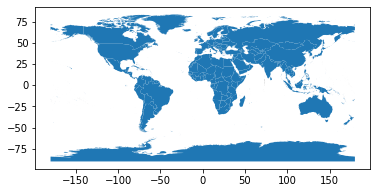

In [23]:
countries_gdf.plot()

In [30]:
countries_gdf['lon'] = countries_gdf.to_crs('+proj=cea').centroid.to_crs(countries_gdf.crs).x
countries_gdf['lat'] = countries_gdf.to_crs('+proj=cea').centroid.to_crs(countries_gdf.crs).y

# Manually correct some unmatched country names

In [31]:
(set(df['source']) | set(df['target'])) - set(countries_gdf['ADMIN'])

{'Bahamas',
 'Bonaire',
 'Congo',
 "Cote d'Ivoire",
 'Crimea',
 'Curacao',
 'Democratic Republic of Congo',
 'Eswatini',
 'French Guiana',
 'Guadeloupe',
 'Guinea-Bissau',
 'Guyane',
 'Hong Kong',
 'Martinique',
 'Mayotte',
 'North Macedonia',
 'Republic of the Congo',
 'Reunion',
 'Serbia',
 'Sint Eustatius',
 'The Gambia',
 'Timor-Leste',
 'USA'}

In [32]:
countries_gdf[countries_gdf['ADMIN'].str.contains('Guinea')]

,ADMIN,ISO_A3,geometry,lon,lat
86,Guinea,GIN,"POLYGON ((-13.33861 12.63923, -13.33277 12.639...",-10.9400,10.4283
88,Guinea Bissau,GNB,"MULTIPOLYGON (((-15.90160 11.14228, -15.89485 ...",-14.9777,12.0261
89,Equatorial Guinea,GNQ,"MULTIPOLYGON (((5.64275 -1.46282, 5.62892 -1.4...",10.3331,1.7066
181,Papua New Guinea,PNG,"MULTIPOLYGON (((153.25782 -11.35345, 153.27752...",145.2290,-6.4603


In [33]:
df.replace('USA','United States of America', inplace=True)
df.replace('Republic of the Congo','Republic of Congo', inplace=True)
df.replace('Democratic Republic of Congo','Democratic Republic of the Congo', inplace=True)
df.replace('Hong Kong','Hong Kong S.A.R.', inplace=True)
df.replace('The Gambia','Gambia', inplace=True)
df.replace('Guinea-Bissau','Guinea Bissau', inplace=True)
countries_gdf.replace('Swaziland','Eswatini', inplace=True)
countries_gdf.replace('East Timor','Timor-Leste', inplace=True)
countries_gdf.replace('Ivory Coast',"Cote d'Ivoire", inplace=True)
countries_gdf.replace('Republic of Serbia',"Serbia", inplace=True)
countries_gdf.replace('The Bahamas',"Bahamas", inplace=True)

In [34]:
(set(df['source']) | set(df['target'])) - set(countries_gdf['ADMIN'])

{'Bonaire',
 'Congo',
 'Crimea',
 'Curacao',
 'French Guiana',
 'Guadeloupe',
 'Guyane',
 'Martinique',
 'Mayotte',
 'North Macedonia',
 'Reunion',
 'Sint Eustatius'}

# Export

In [35]:
countries_gdf

,ADMIN,ISO_A3,geometry,lon,lat
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",-69.9742,12.5169
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903...",65.9697,33.7595
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",17.5344,-12.2361
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ...",-63.0586,18.2257
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993...",20.0548,41.1304
...,...,...,...,...,...
250,Samoa,WSM,"MULTIPOLYGON (((-171.57002 -13.93816, -171.564...",-172.1615,-13.7544
251,Yemen,YEM,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12...",47.5815,15.8906
252,South Africa,ZAF,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -...",25.1403,-28.8774
253,Zambia,ZMB,"POLYGON ((31.11984 -8.61663, 31.14102 -8.60619...",27.7907,-13.4283


In [36]:
countries_gdf[['ADMIN','ISO_A3','lon','lat']].to_csv('countries.csv', index=False)

In [142]:
# precompute scaling the value to arc thickness
df['arc_width'] = df['value'].apply(lambda x: (np.log(x)+1)**1.6)
df

,source,total_sequences,target,value,arc_width
0,Afghanistan,16,Germany,16,8.3680
1,Albania,30,Germany,1,1.0000
2,Albania,30,United Kingdom,29,10.5765
3,Algeria,29,France,18,8.7899
4,Andorra,1,Spain,1,1.0000
...,...,...,...,...,...
180,United Kingdom,413494,Netherlands,1,1.0000
181,United Kingdom,413494,United States of America,2,2.3223
182,Uruguay,194,United States of America,44,12.2375
183,Venezuela,113,Colombia,3,3.2741


In [143]:
df.to_csv('graph.csv', index=False)

# PyDeck part

In [ ]:
!pip install pydeck

In [144]:
deck_df = pd.merge(df, countries_gdf[['ADMIN','lon','lat']], left_on='source', right_on=['ADMIN'])
deck_df = pd.merge(deck_df, countries_gdf[['ADMIN','lon','lat']], left_on='target', right_on=['ADMIN'], suffixes=['_s','_t'])
deck_df

,source,total_sequences,target,value,arc_width,ADMIN_s,lon_s,lat_s,ADMIN_t,lon_t,lat_t
0,Afghanistan,16,Germany,16,8.3680,Afghanistan,65.9697,33.7595,Germany,10.3711,50.9949
1,Albania,30,Germany,1,1.0000,Albania,20.0548,41.1304,Germany,10.3711,50.9949
2,Armenia,84,Germany,3,3.2741,Armenia,44.9364,40.2813,Germany,10.3711,50.9949
3,Belarus,46,Germany,28,10.4408,Belarus,28.0249,53.4860,Germany,10.3711,50.9949
4,Benin,12,Germany,12,7.3707,Benin,2.3281,9.6312,Germany,10.3711,50.9949
...,...,...,...,...,...,...,...,...,...,...,...
166,Papua New Guinea,425,Australia,359,21.9017,Papua New Guinea,145.2290,-6.4603,Australia,134.3904,-25.2611
167,Timor-Leste,19,Australia,19,8.9862,Timor-Leste,125.8514,-8.8235,Australia,134.3904,-25.2611
168,Sierra Leone,15,Ghana,4,4.0212,Sierra Leone,-11.7950,8.5611,Ghana,-1.2166,7.9439
169,Togo,124,Ghana,11,7.0784,Togo,0.9630,8.5199,Ghana,-1.2166,7.9439


In [173]:
deck_df[['value','arc_width']].value_counts()

value  arc_width
1      1.0000       29
2      2.3223       15
3      3.2741        9
5      4.6395        8
4      4.0212        7
                    ..
68     14.0672       1
74     14.4336       1
76     14.5499       1
81     14.8291       1
893    26.7220       1
Length: 63, dtype: int64

In [169]:
import pydeck as pdk

SOURCE_RGB = [51, 177, 255, 70]
TARGET_RGB = [255, 123, 0, 40]

# Specify a deck.gl ArcLayer
arc_layer = pdk.Layer(
    "ArcLayer",
    data=deck_df,
    get_width="arc_width",
    width_scale=0.5,
    width_min_pixels=1,
    width_max_pixels=30,
    get_source_position=["lon_s", "lat_s"],
    get_target_position=["lon_t", "lat_t"],
    get_tilt=5,
    get_source_color=SOURCE_RGB,
    get_target_color=TARGET_RGB,
    pickable=True,
    auto_highlight=True,
)

view_state = pdk.ViewState(latitude=40, longitude=0, bearing=-15, pitch=30, zoom=1.4,)
view = pdk.View(type="MapView", controller=True)

TOOLTIP_TEXT = {"html": "{value} samples from {source} sequenced and submitted by {target}"}
r = pdk.Deck(arc_layer, initial_view_state=view_state, tooltip=TOOLTIP_TEXT, map_style='dark', views=[view])
# r.to_html("arc_layer.html")

In [170]:
r.to_html("gisaid-sequencing-arcmap.html", notebook_display=True)

<IPython.core.display.Javascript object>

'<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv="content-type" content="text/html; charset=UTF-8" />\n    <title>pydeck</title>\n        <script src="https://api.tiles.mapbox.com/mapbox-gl-js/v1.13.0/mapbox-gl.js"></script>\n        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css" />\n    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css" />\n    <script src=\'https://cdn.jsdelivr.net/npm/@deck.gl/jupyter-widget@~8.5.*/dist/index.js\'></script>\n    <style>\n    body {\n  margin: 0;\n  padding: 0;\n  overflow: hidden;\n}\n\n#deck-map-container {\n  width: 100%;\n  height: 100%;\n  background-color: black;\n}\n\n#map {\n  pointer-events: none;\n  height: 100%;\n  width: 100%;\n  position: absolute;\n  z-index: 1;\n}\n\n#deckgl-overlay {\n  z-index: 2;\n  background: none;\n}\n\n#deck-map-wrapper {\n  width: 100%;\n  height: 100%;\n}\n\n#deck-container {\n  width: 100v